# 앙상블 학습과 랜덤 포레스트

대중의 지혜 : 무작위로 선택된 수천 명의 사람에게 복잡한 질문하고 대답을 모은다고 가정합시다.

많은 경우 이렇게 모은 답이 전문가의 답보다 낫다는 것을 알 수 있음.

이처럼 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델하나보다 더 좋은 예측을 얻을 수 있음.

|

일련의 예측기를 앙상블이라고 부르기 때문에 앙상블 학습이라고 함.

앙상블의 방법의 예를 들면 훈련세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를

훈련시킬 수 있음. 예측을 하려면 모든 개별트리의 예측을 구하면 됨.

|

결정트리의 앙상블을 랜덤 포레스트라고 함. (6장 마지막 연습문제 참고) 간단한 방법임에도 랜덤포레스트는 

오늘날 가장 강력한 머신러닝 알고리즘 중 하나임. 사실 머신러닝 대회에서 우승하는 솔루션은 여러가지

앙상블 방법을 사용한 경우가 많음. 특히 넷플릭스 대회에서 가장 인기있음.

이 장에서는 배깅, 부스팅, 스태킹 등 가장 인기있는 앙상블을 설명합니다. (+ 랜덤포레스트)

## 투표 기반 분류기

정확도가 80%인 분류기 여러개를 훈련시켰다고 가정하고,

아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있음.

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측.

이렇게 다수결 투표로 정해지는 분류기를 직접투표 분류기라고 합니다.

조금 놀랍게도 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 

가장 뛰어난 것보다도 정확도가 높을 것. 사실 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면

앙상블은 강한 학습기가 될 수 있음.

|

이게 어떻게 가능할까요? 다음 설명이 이 미스터리를 조금 밝혀줄 겁니다.

동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 균형이 맞지 않는 동전이 있다고 가정하겠습니다.

이 동전을 1,000번 던진다면 대략 510번은 앞면, 490번은 뒷면이 나올 것이므로 다수는 앞면이 됨.

수학적으로 계산하면, 1,000번 던진 후 앞면에 있을 확률은 75%에 가깝다는 것을 확인할 수 있음.

더 많이 던질수록 확률은 증가합니다. (예를 들어 10,000번 던지면 확률이 97%이상으로 올라감.)

In [1]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import sys
import os

이는 큰 수의 법칙 때문인데, 이로 인해 동전을 자꾸 던질수록 앞면이 나올 비율은 점점 

더 앞면이 나올 확률 (51%)에 가까워짐. [그림 7-3]은 균형이 틀어진 동전을 10번 실험한 그래프.

던진 횟수가 증가할수록 앞면이 나올 확률 51%에 가까워지고, 결국 10번의 실험 모두 50%보다 높게

유지되며 51%에 수렴하면서 끝나고 있음.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

**<그림 7-3. 큰 수의 법칙> 생성 코드**

그림 저장: [7-3] law_of_large_numbers_plot


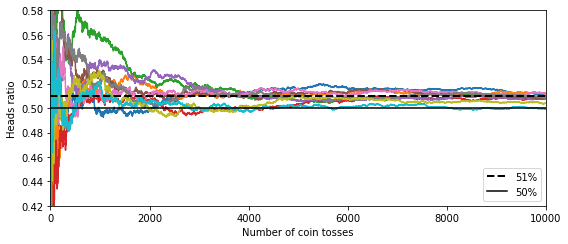

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("[7-3] law_of_large_numbers_plot")
plt.show()

이와 비슷하게 (무작위 추측보다 좀 더 나은) 51% 정확도를 가진 1,000개의 분류기로

앙상블 모델을 구축한다고 가정. 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대가능!

하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능.

하지만 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음.

분류기들은 같은 종류의 오차를 만들기 쉽기 때문에 

잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐.

#### TIP_

앙상블 방법은 각기 다른 알고리즘으로 학습시키면 앙상블 모델의 정확도 향상에 도움됨.

다음은 여러분류기를 조합해 사이킷런의 투표기반 분류기(VotingClassifier)를 만들어 훈련시키는 코드.

(데이터셋은 5장에서 설명한 moons.)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

각 분류기의 테스트셋 정확도를 확인해봅시다.

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


예상대로 투표기반 분류기가 다른 개별 분류기보다 성능이 조금 높음.

모든 분류기가 클래스의 확률을 예측할 수 있으면 (즉, predict_proba() 메서드가 있으면).

개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음. => 간접투표

|

이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접투표 방식보다 성능이 높음.

이 방식을 사용하려면 voting="hard" -> voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 

추정할 수 있으면 됨. SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를

True로 지정해야 함.

(이렇게 하면 클래스 확률을 추정하기 위해 교차검증을 사용하므로 훈련속도가 느려지지만 

SVC에서 predict_proba() 메서드를 사용할 수 있음.)

앞의 코드를 간접 투표 방식으로 사용하도록 변경하면 좀 더 높은 정확도를 얻을 것.

간접 투표 방식

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅과 페이스팅

* 배깅 : 훈련세트에서 중복을 허용하여 샘플링하는 방식

* 페이스팅 : 중복을 허용하지 않고 샘플링하는 방식

배깅과 페이스팅에서는 같은 훈련 샘플을 여러개의 예측기에 걸쳐 사용할 수 있음.

하지만 배깅만이 한 예측기를 위해 같은 훈련샘플을 여러 번 샘플링할 수 있음.

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만듦.

수집함수는 전형적으로 분류일 때는 통계적 최빈값 (즉, 직접투표 분류기처럼 가장 많은 예측결과)이고

회귀에 대해서는 평균을 계산. 

|

개별 예측기는 원본훈련세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만

수집함수를 통과하면 편향과 분산이 모두 감소함. 일반적으로 앙상블의 결과는 원본 데이터셋으로

하나의 예측기를 훈련시킬때와 비교해 편향은 비슷하지만 분산은 줄어듦.

예측기는 모두 동시에 다른 CPU코어나 서버에서 병렬로 학습시킬 수 있음.

이와 유사하게 예측도 병렬로 수행가능. 이런 확장성 덕분에 배깅과 페이스팅이 인기가 높음.

### 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier

(회귀의 경우에는 BaggingRegressor)를 제공. 다음은 결정트리 분류기 500개의 앙상블을 훈련시키는 코드.

각 분류기는 훈련세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨.

(이는 배깅의 경우이고, 대신 페이스팅을 사용하려면 bootstrap=False로 지정하면 됨.)

n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정함.

(-1로 지정하면 가용한 모든 코어 사용.)

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: [7-5] decision_tree_without_and_with_bagging_plot


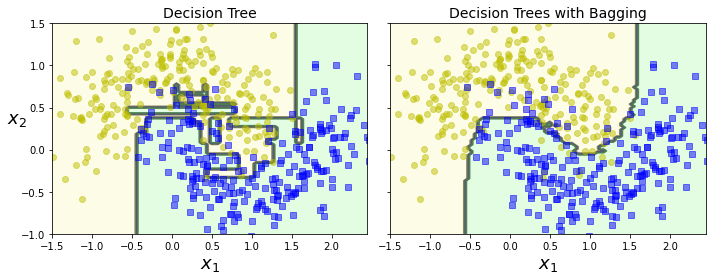

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("[7-5] decision_tree_without_and_with_bagging_plot")
plt.show()

#### NOTE_

BaggingClassifier는 기반이 되는 분류기가 결정트리 분류기처럼 클래스 확률을 추정할 수 있으면

(즉, predict_proba()가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용.

[7-5]는 단일 결정트리의 결정경계와 500개의 트리를 사용한 배깅 앙상블(이전코드로 만든 모델)의

결정경계를 비교할 것임. 둘 다 moons 데이터셋에 훈련시킴. 여기서 볼 수 있듯이 앙상블의 예측이

결정트리 하나의 예측보다 일반화가 훨씬 잘된 것 같음. 앙상블은 비슷한 편향에서

더 작은 분산을 만듦.(훈련세트의 오차 수가 거의 비슷하나 결정경계는 덜 불규칙함.)

|

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 

페이스팅보다 편향이 조금 더 높음. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를

줄이므로 앙상블의 분산을 감소시킴. 

|

전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로

더 선호. 그러나 시간과 CPU파워에 여유가 있다면 교차검증으로 배깅과 페이스팅을

모두 평가해서 더 나은 쪽을 선택하는 것이 좋음.

### oob 평가

배깅을 사용하면 특정 샘플만 샘플링되고 다른 것은 전혀 선택되지 않을 수 있음.

BaggingClassifier는 기본값으로 중복을 허용해(bootstrap=True) 훈현세트의 크기만큼 m개의 샘플을 선택

이는 평균적으로 63%정도만 샘플링 된다는 의미. 

|

이렇게 선택되지 않은 샘플의 나머지 37%를 oob 샘플이라고 함.

예측기마다 남겨진 37%는 모두 다름.

예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 oob 샘플을 사용해 평가할 수 있음.

앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻음.

|

사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후

자동으로 oob평가를 수행. 다음코드는 그 과정을 보여줌. 평과점수결과는 accuracy_score 변수에 저장.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40, n_jobs=-1)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

oob평가 결과를 보면 이 BaggingClassifier는 테스트 세트에서 약 90.1%의 정확도를 얻을 것.

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트세트에서 91.2%의 정확도를 얻었음. 매우 비슷!

oob 샘플에 대한 결정함수의 값도 oob_decision_function_ 변수에서 확인가능.

이 경우 결정함수는 각 훈련샘플의 클래스 확률을 반환함.

(기반이 되는 예측기가 predict_proba()를 가지고 있기 때문에)

다음 예를 보면 oob평가는 첫번째 훈련샘플이 양성클래스에 속할 확률을 67.72%로 추정하고 있음.

(음성클래스에 속할 확률은 32.27%)

In [16]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원. 샘플링은 max_features, bootstrap_features 

두 매개변수로 조절됨. 작동방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링.

따라서 각 예측기는 무작위로 선택한 입력 특서으이 일부분으로 훈련됨.

|

이 기법은 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용함.

훈련특성과 샘플을 모두 샘플링하는 것을 랜덤패치방식이라고 함.

훈련샘플을 모두 사용하고(bootstrap=False이고 max_samples=1.0로 설정) 특성은 샘플링하는

(bootstrap_features=True 그리고/또는 max_features < 1.0) 것을 랜덤 서브스페이스 방식.

특성 샘플링은 더 다양한 예측기를 만들면 편향을 늘리는 대신 분산을 낮춤.

## 랜덤 포레스트

앞서 언급했듯이 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정트리의 앙상블.

전형적으로 max_samples를 훈련세트의 크기로 지정. BaggingClassifier에 DecisionTreeClassifier를

넣어 만드는 대신 결정트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음.

(비슷하게 회귀 문제를 위한 RandomForestRegressor가 있음)

|

다음은 (최대 16개의 리프노드를 갖는) 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 

CPU 코어에서 훈련시키는 코드.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 비슷합니다 :

In [20]:
'''
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)'''

'\nbag_clf = BaggingClassifier(\n    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),\n    n_estimators=500, random_state=42)'

In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

RandomForestClassifier는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) 

Decision Tree Classifier의 매개변수와 앙상블 자체를 제어하는데 필요한 

BaggingClassifier의 매개변수를 모두 가지고 있음.

|

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체특성 중에서 최선의 특성을 찾는 대신

무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함.(6장 참조)

이는 결국 트리를 더욱 다양하게 만들고 (다시 한번) 편향을 손해보는 

대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄.

다음은 BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것.

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

### 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용.

트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로

분할한 다음 그중에서 최상의 분할을 선택.

|

극단적으로 무작위한 트리의 랜덤포레스트를 익스트림 랜덤 트리 앙상블(또는 엑스트라 트리)라고 함.

여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 됨. 모든 노드에서 특성마다 

가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로

일반적인 랜덤 포레스트보다 엑스트라트리가 훨씬 빠름.

|

엑스트라 트리를 만들려면 사이킷런의 ExtraTreesClassifier를 사용함.

사용법은 RandomForestClassifier와 같음. 마찬가지로 ExtraTreesClassifier도 

RandomForestRegressor와 같은 API를 제공함.

### 특성 중요도

랜덤포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉬움.

사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인해 특성의 중요도 측정.

더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.

|

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록

결괏값을 정규화함. 이 값은 feature_importances_ 변수에 저장되어 있음.

예를 들어 다음 코드는 (4장에서 소개한) iris 데이터셋에 

RandomForestClassifier를 훈련시키고 각 특성을 출력함.

|

가장 중요한 특성은 꽃잎의 길이(44%)와 너비(42%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해 보임.

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [25]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

이와 유사하게 (3장에) MNIST 데이터셋에 랜덤포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 

그래프로 나타내면 [7-6]과 같은 이미지가 나옴.

랜덤포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리.

In [26]:
'''from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])'''

RandomForestClassifier(random_state=42)

그림 저장: [7-6] mnist_feature_importance_plot


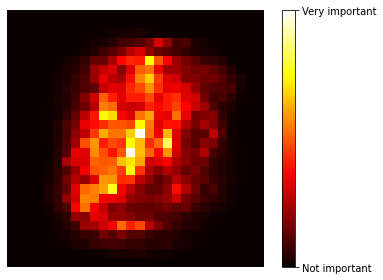

In [28]:
'''def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("[7-6] mnist_feature_importance_plot")
plt.show()'''

## 부스팅

부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말함.

부스팅의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것.

부스팅에는 여러가지가 있지만 가장 인기있는 것은 에이다부스트와 그레디언트 부스팅.

에이다부스트부터 시작해보자.

### 에이다부스트



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### 그레디언트 부스팅

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

이제 이 데이터셋에 결정 트리 회귀 모델을 훈련시킵니다:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

**<그림 7-9> 생성 코드**

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀 모델을 사용해 보죠:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

**<그림 7-10. 예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블> 생성 코드**

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**조기 종료를 사용한 그래디언트 부스팅**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)